In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import entropy

# Load JSON data into a Polars DataFrame
df = pl.read_json("..\game_data.json")

# Check the first few rows
df.head()


tag_Medium,playing_time,tag_strategygames,tag_partygames,tag_familygames,tag_Very Long,rank_subcategory_2,wished_by,popularity_score,tag_Teen,tag_Unknown,is_solo_game,num_weights,categories,game_rank,avg_weight,suggested_play_age,tag_cgs,tag_thematic,tag_abstracts,min_players,tag_Long,description,tag_Short,subcategory_2,tag_Family,recommended_num_players,is_party_game,num_rates,language_dependence_description,owned_by,age_group,tag_Kids,tag_childrensgames,avg_rating,is_couple_game,tag_wargames,playing_time_group,is_small_group_game,rank_subcategory_1,tag_Adult,mechanics,subcategory_1,game_name,max_players
i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,list[str],i64,f64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,i64,i64,str,i64,str,i64,i64,f64,i64,i64,str,i64,i64,i64,list[str],str,str,i64
0,240,1,0,0,1,null,2187,0.231305,1,0,0,790,"[""Economic"", ""Negotiation"", ""Political""]",453,4.3101,14,0,0,0,3,0,"""Die Macher is a game about sev…",0,null,0,"""4""",0,5873,"""No necessary in-game text""",8287,"""Teen""",0,0,7.58985,0,0,"""Very Long""",1,262,0,"[""Alliances"", ""Area Majority / Influence"", … ""Simultaneous Action Selection""]","""strategygames""","""Die Macher""",5
0,30,1,0,0,0,null,217,0.142266,0,1,0,56,"[""Card Game"", ""Fantasy""]",5179,1.9643,null,0,0,0,3,0,"""Dragonmaster is a tricktaking …",1,null,0,"""3""",0,603,"""Some necessary text - easily m…",1418,"""Unknown""",0,0,6.66302,0,0,"""Short""",1,2001,0,"[""Trick-taking""]","""strategygames""","""Dragonmaster""",4
1,60,1,0,0,0,null,4092,0.309449,0,0,0,1533,"[""Abstract Strategy"", ""Medieval""]",275,2.4423,10,0,0,0,2,0,"""Samurai is set in medieval Jap…",0,null,1,"""2""",0,16595,"""No necessary in-game text""",17007,"""Family""",0,0,7.47523,1,0,"""Medium""",0,208,0,"[""Area Majority / Influence"", ""Hand Management"", … ""Tile Placement""]","""strategygames""","""Samurai""",4
1,60,1,0,0,0,null,129,0.137282,0,0,0,31,"[""Ancient""]",6904,2.6774,12,0,0,0,2,0,"""When you see the triangular bo…",0,null,1,"""4""",0,358,"""No necessary in-game text""",701,"""Family""",0,0,6.60939,1,0,"""Medium""",0,2179,0,"[""Action Points"", ""Area Majority / Influence"", … ""Set Collection""]","""strategygames""","""Tal der Könige""",4
0,90,1,0,0,0,null,3396,0.31637,0,0,0,1675,"[""Economic"", ""Territory Building""]",345,2.4937,12,0,0,0,2,1,"""In Acquire, each player strate…",0,null,1,"""3""",1,21094,"""No necessary in-game text""",28149,"""Family""",0,0,7.35039,1,0,"""Long""",0,270,0,"[""Hand Management"", ""Investment"", … ""Victory Points as a Resource""]","""strategygames""","""Acquire""",6


In [2]:
# Convert categories into a binary matrix using CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False, binary=True)
X = vectorizer.fit_transform(df["categories"].to_list()).toarray()

# Extract category names
category_names = vectorizer.get_feature_names_out()


c:\Users\hcvaldrez\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


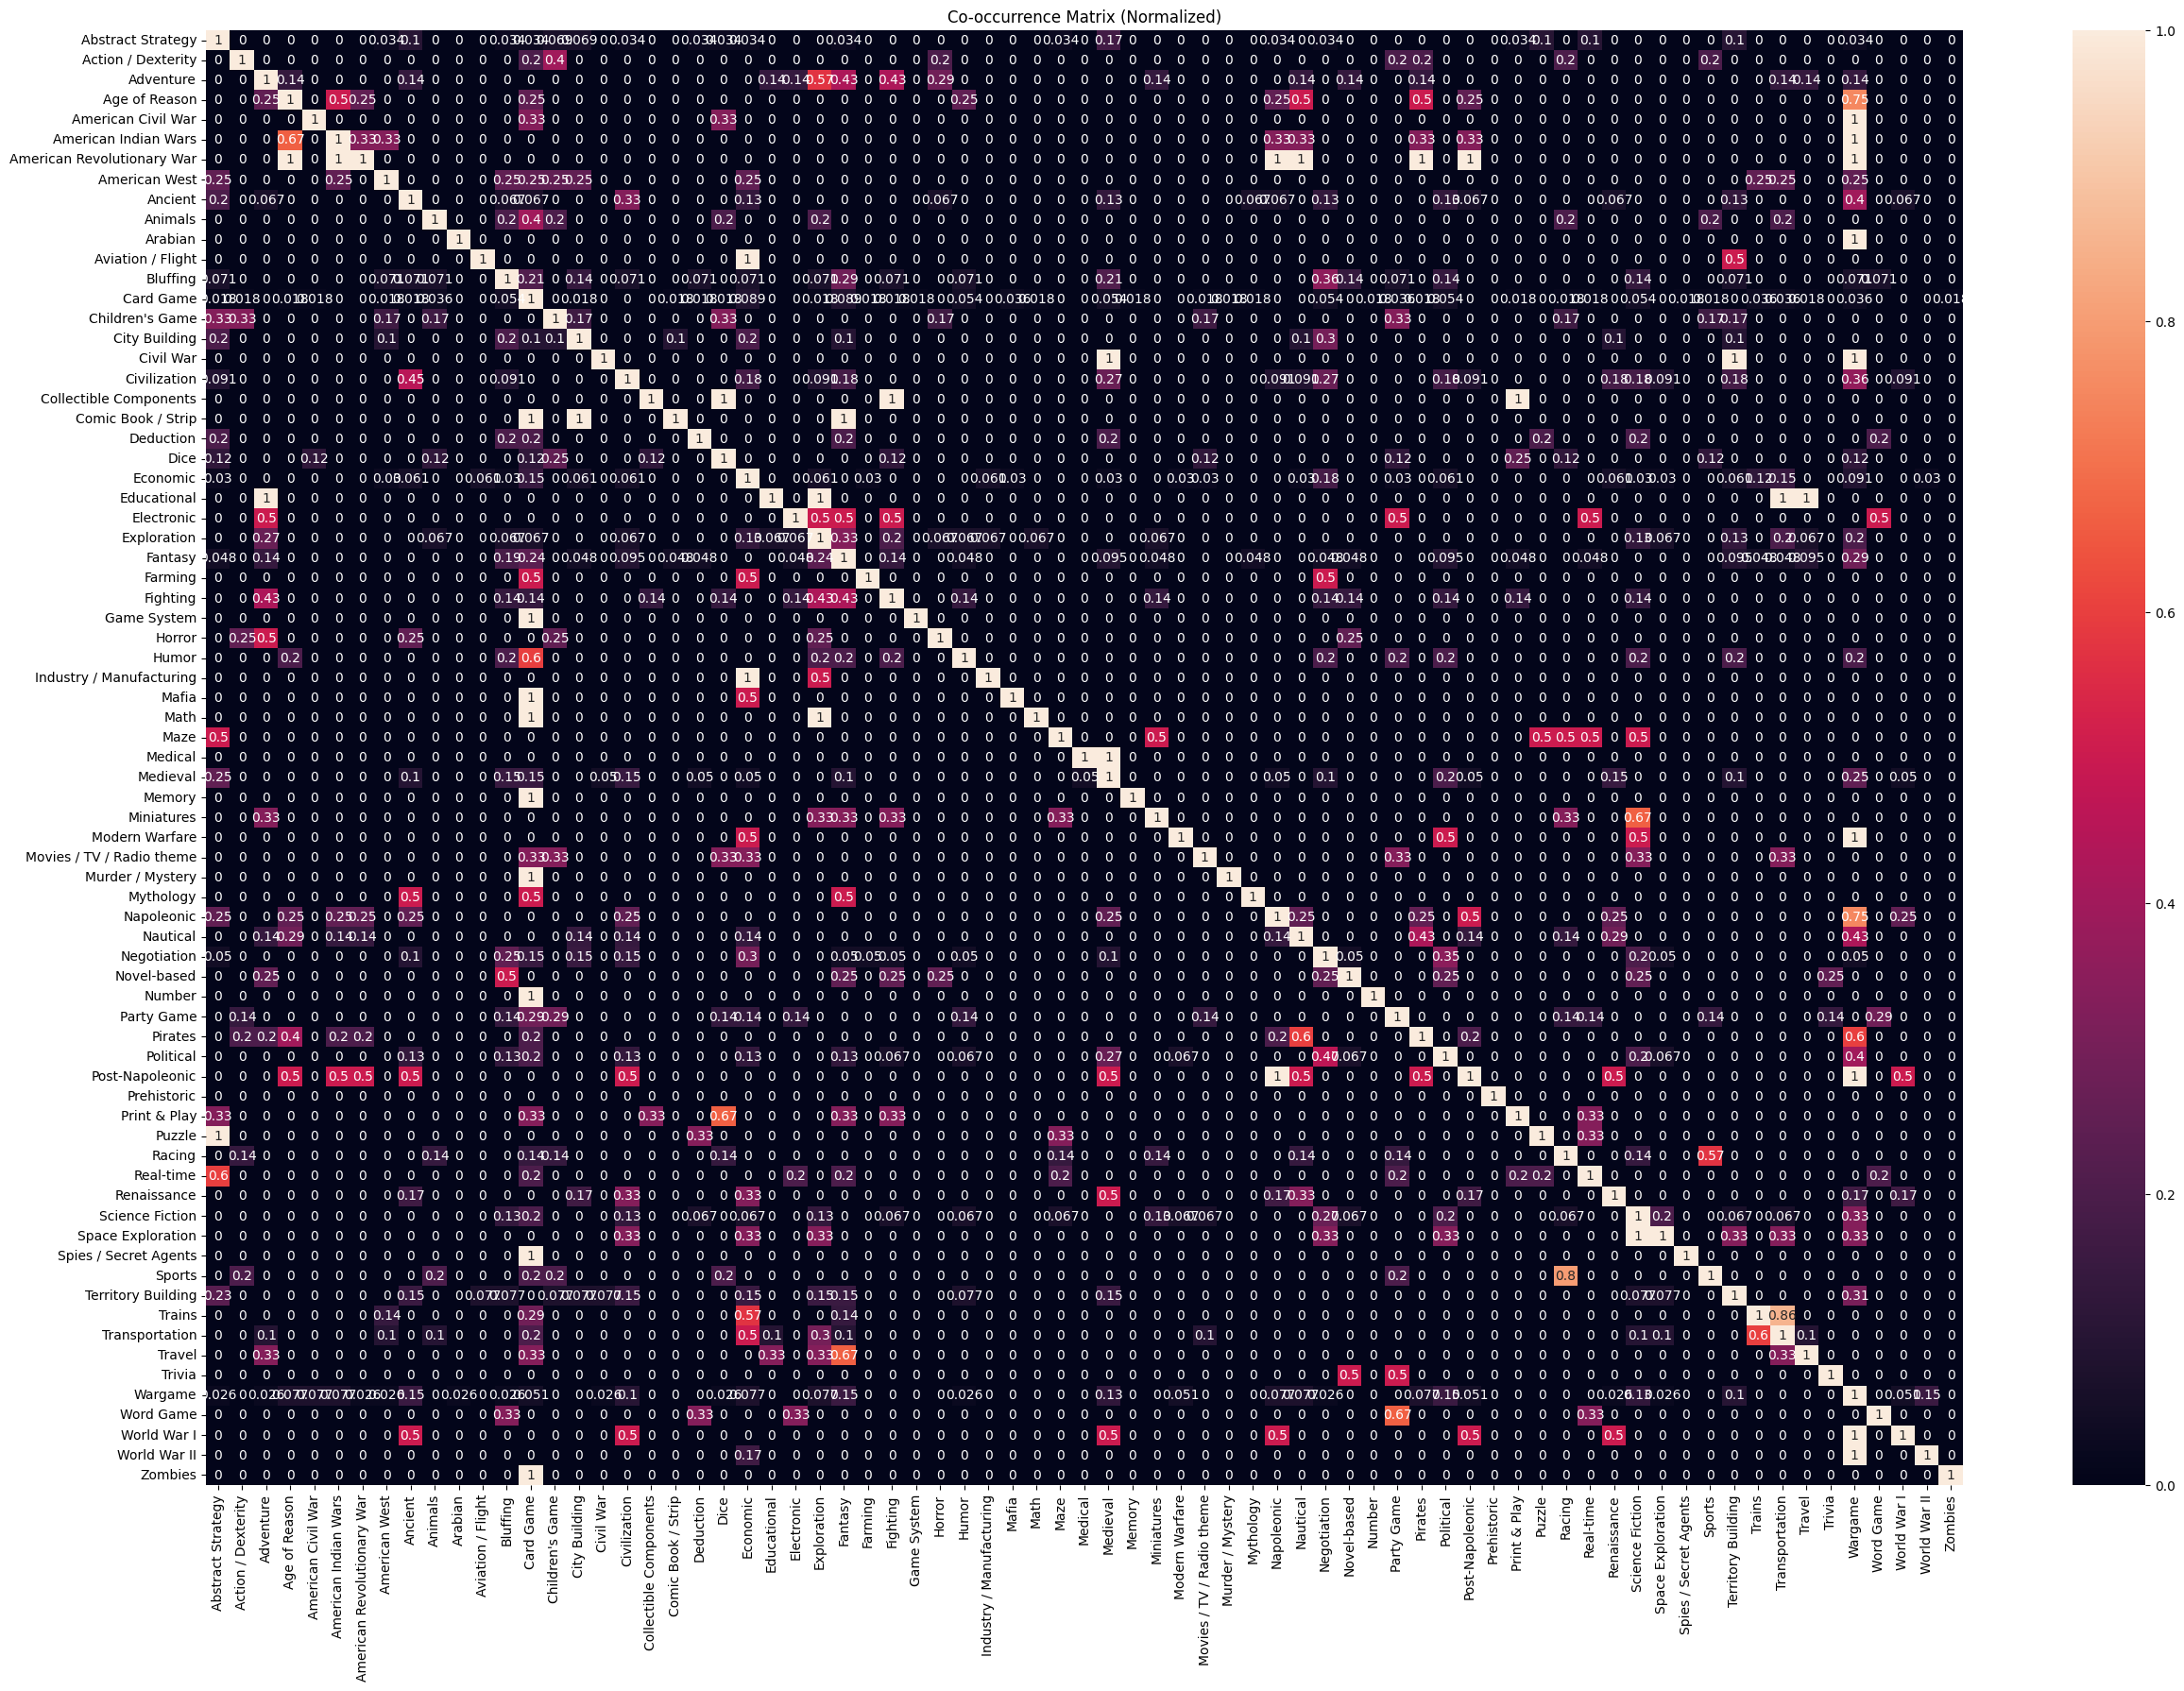

In [3]:
# Compute the co-occurrence matrix
co_occurrence = X.T @ X

# Normalize co-occurrence matrix
co_occurrence_norm = co_occurrence / np.diag(co_occurrence)[:, None]

# Visualize the co-occurrence matrix as a heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(co_occurrence_norm, annot=True, xticklabels=category_names, yticklabels=category_names)
plt.title("Co-occurrence Matrix (Normalized)")
plt.show()

In [4]:
# Extract upper-triangle values (excluding diagonal)
values = co_occurrence_norm[np.triu_indices_from(co_occurrence_norm, k=1)]

# Define threshold using Z-score method
threshold = np.mean(values) + 2 * np.std(values)

# Identify redundant category pairs
redundant_pairs = np.argwhere(co_occurrence_norm > threshold)
redundant_pairs = [(category_names[i], category_names[j]) for i, j in redundant_pairs if i != j]

# Print redundant category pairs
for cat1, cat2 in redundant_pairs:
    print(f"Redundant (Co-occurrence): {cat1} → {cat2}")

Redundant (Co-occurrence): Action / Dexterity → Children's Game
Redundant (Co-occurrence): Adventure → Exploration
Redundant (Co-occurrence): Adventure → Fantasy
Redundant (Co-occurrence): Adventure → Fighting
Redundant (Co-occurrence): Adventure → Horror
Redundant (Co-occurrence): Age of Reason → American Indian Wars
Redundant (Co-occurrence): Age of Reason → Nautical
Redundant (Co-occurrence): Age of Reason → Pirates
Redundant (Co-occurrence): Age of Reason → Wargame
Redundant (Co-occurrence): American Civil War → Card Game
Redundant (Co-occurrence): American Civil War → Dice
Redundant (Co-occurrence): American Civil War → Wargame
Redundant (Co-occurrence): American Indian Wars → Age of Reason
Redundant (Co-occurrence): American Indian Wars → American Revolutionary War
Redundant (Co-occurrence): American Indian Wars → American West
Redundant (Co-occurrence): American Indian Wars → Napoleonic
Redundant (Co-occurrence): American Indian Wars → Nautical
Redundant (Co-occurrence): America

In [5]:
# Prevent division by zero
eps = 1e-10

# Compute individual and joint probabilities
p_i = np.sum(X, axis=0) / X.shape[0] + eps
p_ij = co_occurrence / X.shape[0] + eps

# Compute PMI
pmi = np.log2(p_ij / (p_i[:, None] * p_i[None, :]))

# Replace NaN and infinite values with zero
pmi = np.nan_to_num(pmi, nan=0.0, posinf=0.0, neginf=0.0)

# Define threshold for significant PMI pairs
mean_pmi, std_pmi = np.nanmean(pmi), np.nanstd(pmi)
threshold = mean_pmi + 2 * std_pmi

# Identify redundant pairs based on PMI
redundant_pairs_pmi = np.argwhere(pmi > threshold)
redundant_pairs_pmi = [(category_names[i], category_names[j]) for i, j in redundant_pairs_pmi if i != j]

# Print redundant category pairs
for cat1, cat2 in redundant_pairs_pmi:
    print(f"PMI Redundant Pair: {cat1} → {cat2}")

PMI Redundant Pair: Abstract Strategy → American West
PMI Redundant Pair: Abstract Strategy → Ancient
PMI Redundant Pair: Abstract Strategy → Bluffing
PMI Redundant Pair: Abstract Strategy → Children's Game
PMI Redundant Pair: Abstract Strategy → City Building
PMI Redundant Pair: Abstract Strategy → Civilization
PMI Redundant Pair: Abstract Strategy → Deduction
PMI Redundant Pair: Abstract Strategy → Dice
PMI Redundant Pair: Abstract Strategy → Maze
PMI Redundant Pair: Abstract Strategy → Medieval
PMI Redundant Pair: Abstract Strategy → Napoleonic
PMI Redundant Pair: Abstract Strategy → Print & Play
PMI Redundant Pair: Abstract Strategy → Puzzle
PMI Redundant Pair: Abstract Strategy → Real-time
PMI Redundant Pair: Abstract Strategy → Territory Building
PMI Redundant Pair: Action / Dexterity → Card Game
PMI Redundant Pair: Action / Dexterity → Children's Game
PMI Redundant Pair: Action / Dexterity → Horror
PMI Redundant Pair: Action / Dexterity → Party Game
PMI Redundant Pair: Action / 

In [6]:
# Convert categories to one-hot encoding
df_expanded = df.with_columns(
    pl.col("categories").map_elements(
        lambda x: {category: True for category in x}, return_dtype=pl.Struct
    )
).unnest("categories").fill_null(False)

# Convert to Pandas DataFrame
df_pandas = df_expanded.to_pandas()

# Select boolean columns for Apriori analysis
boolean_columns = df_pandas.select_dtypes(include=['bool']).columns
df_pandas_bool = df_pandas[boolean_columns]

# Run Apriori algorithm with lower minimum support
frequent_itemsets = apriori(df_pandas_bool, min_support=0.01, use_colnames=True)

# Generate association rules based on lift
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
rules_filtered = rules[rules["lift"] > 2.0]  # Adjust threshold as needed
rules_sorted = rules_filtered.sort_values('lift', ascending=False)

# Set display options to show all rows and columns
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("All Association Rules by Lift:")
print(rules_sorted)

print("\nNumber of rules found:", len(rules_filtered))
print("\nSummary Statistics:")
print(rules_filtered[['support', 'confidence', 'lift']].describe())

# Optional: Reset display options to default after printing
pd.reset_option('all')

All Association Rules by Lift:
                            antecedents                         consequents  \
154                (Fantasy, Adventure)             (Exploration, Fighting)   
159             (Exploration, Fighting)                (Fantasy, Adventure)   
157            (Exploration, Adventure)                 (Fantasy, Fighting)   
156                 (Fantasy, Fighting)            (Exploration, Adventure)   
158               (Adventure, Fighting)              (Fantasy, Exploration)   
143                           (Pirates)                 (Wargame, Nautical)   
155              (Fantasy, Exploration)               (Adventure, Fighting)   
138                 (Wargame, Nautical)                           (Pirates)   
142                          (Nautical)                  (Wargame, Pirates)   
163                          (Fighting)   (Fantasy, Adventure, Exploration)   
148                         (Adventure)             (Exploration, Fighting)   
137                  

C:\Users\hcvaldrez\AppData\Local\Temp\ipykernel_19820\3989929340.py:37: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\hcvaldrez\AppData\Local\Temp\ipykernel_19820\3989929340.py:37: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


In [7]:
# Compute entropy for each category
category_entropy = entropy(X.T, axis=1)

# Create a sorted list of categories and entropy values in descending order
sorted_entropy = sorted(zip(category_names, category_entropy), key=lambda x: x[1], reverse=True)

# Display sorted entropy values
print("Category Entropy (Sorted Descending):")
for category, ent in sorted_entropy:
    print(f"{category}: {ent:.4f}")

# Define threshold for low entropy categories
mean_entropy, std_entropy = np.mean(category_entropy), np.std(category_entropy)
low_entropy_threshold = mean_entropy - std_entropy

# Identify categories to remove
categories_to_remove = [category for category, ent in sorted_entropy if ent < low_entropy_threshold]

# Print results
print(f"\nLow entropy threshold: {low_entropy_threshold:.4f}")
print("Categories to remove based on entropy:", categories_to_remove)


Category Entropy (Sorted Descending):
Card Game: 4.0254
Wargame: 3.6636
Economic: 3.4965
Abstract Strategy: 3.3673
Fantasy: 3.0445
Medieval: 2.9957
Negotiation: 2.9957
Ancient: 2.7081
Exploration: 2.7081
Political: 2.7081
Science Fiction: 2.7081
Bluffing: 2.6391
Territory Building: 2.5649
Civilization: 2.3979
City Building: 2.3026
Transportation: 2.3026
Dice: 2.0794
Adventure: 1.9459
Fighting: 1.9459
Nautical: 1.9459
Party Game: 1.9459
Racing: 1.9459
Trains: 1.9459
Children's Game: 1.7918
Renaissance: 1.7918
World War II: 1.7918
Action / Dexterity: 1.6094
Animals: 1.6094
Deduction: 1.6094
Humor: 1.6094
Pirates: 1.6094
Real-time: 1.6094
Sports: 1.6094
Age of Reason: 1.3863
American West: 1.3863
Horror: 1.3863
Napoleonic: 1.3863
Novel-based: 1.3863
American Civil War: 1.0986
American Indian Wars: 1.0986
Miniatures: 1.0986
Movies / TV / Radio theme: 1.0986
Print & Play: 1.0986
Puzzle: 1.0986
Space Exploration: 1.0986
Travel: 1.0986
Word Game: 1.0986
Aviation / Flight: 0.6931
Electronic: 0

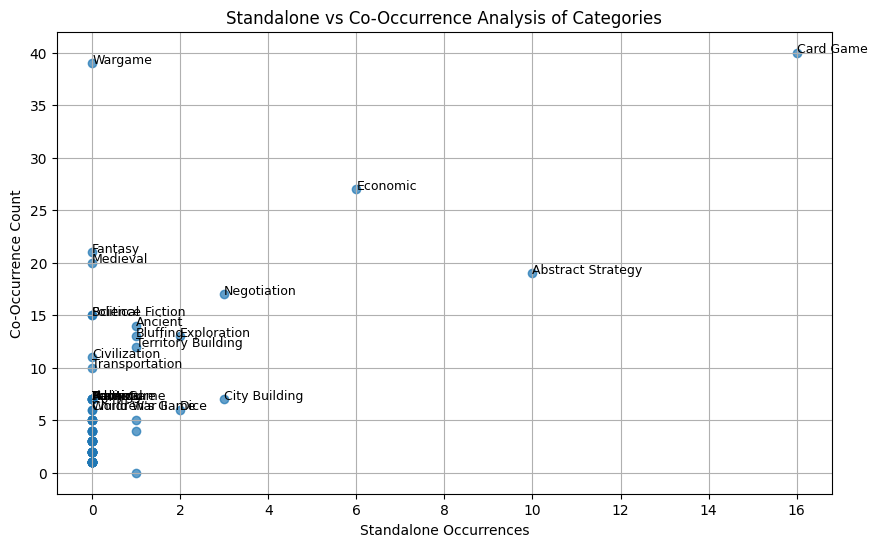

In [11]:

# Get all unique categories
category_list = df["categories"].explode().unique().to_list()

# Initialize dictionaries for counts
standalone_counts = {category: 0 for category in category_list}
co_occurrence_counts = {category: 0 for category in category_list}

# Count standalone and co-occurrence
for row in df["categories"]:
    if len(row) == 1:
        standalone_counts[row[0]] += 1  # Single category game
    else:
        for category in row:
            co_occurrence_counts[category] += 1  # Appears with others

# Convert counts to arrays
x_values = np.array([standalone_counts[cat] for cat in category_list])
y_values = np.array([co_occurrence_counts[cat] for cat in category_list])

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.7)

# Annotate top categories
for i, category in enumerate(category_list):
    if x_values[i] > 5 or y_values[i] > 5:  # Adjust threshold for labeling
        plt.annotate(category, (x_values[i], y_values[i]), fontsize=9)

# Formatting
plt.xlabel("Standalone Occurrences")
plt.ylabel("Co-Occurrence Count")
plt.title("Standalone vs Co-Occurrence Analysis of Categories")
plt.grid(True)
plt.show()


In [17]:
# Count how many times each category appears in any game
category_counts = df["categories"].explode().value_counts()

# Find how many times each category appears in a game alone
solo_counts = (
    df.filter(df["categories"].list.len() == 1)["categories"]
    .explode()
    .value_counts()
)

# Convert to dictionaries for easy lookup
category_total_dict = dict(zip(category_counts["categories"], category_counts["counts"]))
solo_count_dict = dict(zip(solo_counts["categories"], solo_counts["counts"]))

# Identify categories that appear **only solo** (their total count == their solo count)
solo_only_categories = [
    cat for cat in solo_count_dict if solo_count_dict[cat] == category_total_dict[cat]
]

# Identify categories that **never appear solo** (i.e., not in the solo count dictionary)
co_occurring_categories = [
    cat for cat in category_total_dict if cat not in solo_count_dict
]

# Print results
print("\nCategories that ONLY appear solo:")
print(solo_only_categories)

print("\nCategories that ONLY appear together with others:")
print(co_occurring_categories)


ColumnNotFoundError: "counts" not found